In [34]:
import pandas as pd
import numpy as np
import torch
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from eunjeon import Mecab

plt.rc('font', family='Malgun Gothic')

In [35]:
data_dir = '../analysis_files/files/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
# 감성대화말뭉치(최종데이터)_Training.csv 파일을 pandas로 읽어옵니다.
df = pd.read_csv(os.path.join(data_dir, '감성대화말뭉치(최종데이터)_Validation.csv'), encoding='cp949')
df = df[['사람문장1', '시스템문장1', '사람문장2','시스템문장2','사람문장3','시스템문장3','감정_대분류', '상황키워드']]

In [37]:
# NaN 값을 빈 문자열로 채우기
df.fillna('', inplace=True)

# 정규식을 이용하여 한국어 문장 추출
korean_pattern = re.compile('[가-힣]+')
df['korean_sentences'] = df.apply(lambda row: ' '.join(korean_pattern.findall(' '.join(row))), axis=1)

# 한국어 문장이 없는 행 제거
df = df[df['korean_sentences'] != '']

In [38]:
# 형태소 분석기 초기화
mecab = Mecab()

# 형태소 분석을 통해 명사 추출
df['nouns'] = df['korean_sentences'].apply(lambda sentence: ' '.join(mecab.nouns(sentence)))

# 텍스트 데이터 전처리
documents = df['nouns'].tolist()

In [39]:
documents[:5]

['이번 프로젝트 발표 내 실수 바람 우리 팀 감점 미안 실수 미안 마음 내 능력 부족 거 거 능력 방법 퇴근 후 여가 회사 일 피해 결과 불안 진로 취업 직장',
 '회사 프로젝트 혼자 프로젝트 혼자 고민 나 중요 프로젝트 느낌 프로젝트 걸 수 동료 직원 도움 요청 해결 동료 직원 도움 요청 불안 진로 취업 직장',
 '상사 게 직장 상사 게 업무 것 말 상사 분과 수 방법 무엇 말 게 직장 상사 불안 진로 취업 직장',
 '이번 직장 직장 긴장 직장 긴장 것 직장 적응 수 적응 무엇 수 직장 동료 상사 직장 적응 불안 진로 취업 직장',
 '직장 동료 관계 걱정 직장 사람 관계 고민 내 낯가림 수 직장 사람 방법 취미 공유 얘기 수 거 직장 사람 관계 응원 불안 진로 취업 직장']

In [40]:
# 단어 벡터화
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(documents)

In [41]:
# LDA 모델 학습
num_topics = 12  # 주제의 수 설정
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=12, random_state=42)

In [42]:
# 주제 및 각 주제별 단어 출력
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()

In [43]:
num_top_words = 5  # 주제당 상위 단어 수
feature_names = vectorizer.get_feature_names_out()

display_topics(lda, feature_names, num_top_words)

Topic 1:
병원 걱정 재정 당황 상황

Topic 2:
친구 학교 폭력 따돌림 선생

Topic 3:
관계 아들 대인 엄마 가족

Topic 4:
건강 죽음 운동 생각 관리

Topic 5:
준비 재정 노후 은퇴 남자

Topic 6:
기분 가족 공부 시간 진로

Topic 7:
남편 자식 관계 대인 자녀

Topic 8:
부모 진로 성적 시험 학업

Topic 9:
직장 회사 취업 스트레스 업무

Topic 10:
결혼 연애 출산 아이 여자

Topic 11:
불안 상황 아빠 걱정 생각

Topic 12:
사람 아내 관계 대인 당황



In [44]:
# 주제별 첫 번째 토픽
topic_words = []
for topic_idx, topic in enumerate(lda.components_):
    topic_words.append(vectorizer.get_feature_names_out()[topic.argsort()[-1:][0]])
print(topic_words)

# 주제별 첫 번째 토픽과 감정_대분류 표시
df['주제별_첫번째_토픽'] = np.array(topic_words)[lda.transform(X).argmax(axis=1)]


['병원', '친구', '관계', '건강', '준비', '기분', '남편', '부모', '직장', '결혼', '불안', '사람']


In [ ]:
# # 주제별 첫 번째 토픽과 감정_대분류의 occurrence matrix 생성
# topic_labels = df['주제별_첫번째_토픽']
# emotion_categories = df['감정_대분류'].unique()
# occurrence_matrix = pd.DataFrame(0, index=emotion_categories, columns=topic_labels)

# for idx, topic_word in enumerate(topic_words):
#     for emotion in emotion_categories:
#         topic_occurrences = df[(df['감정_대분류'] == emotion) & (df['nouns'].str.contains('|'.join(topic_word)))].shape[0]
#         occurrence_matrix.loc[emotion, topic_labels[idx]] = topic_occurrences


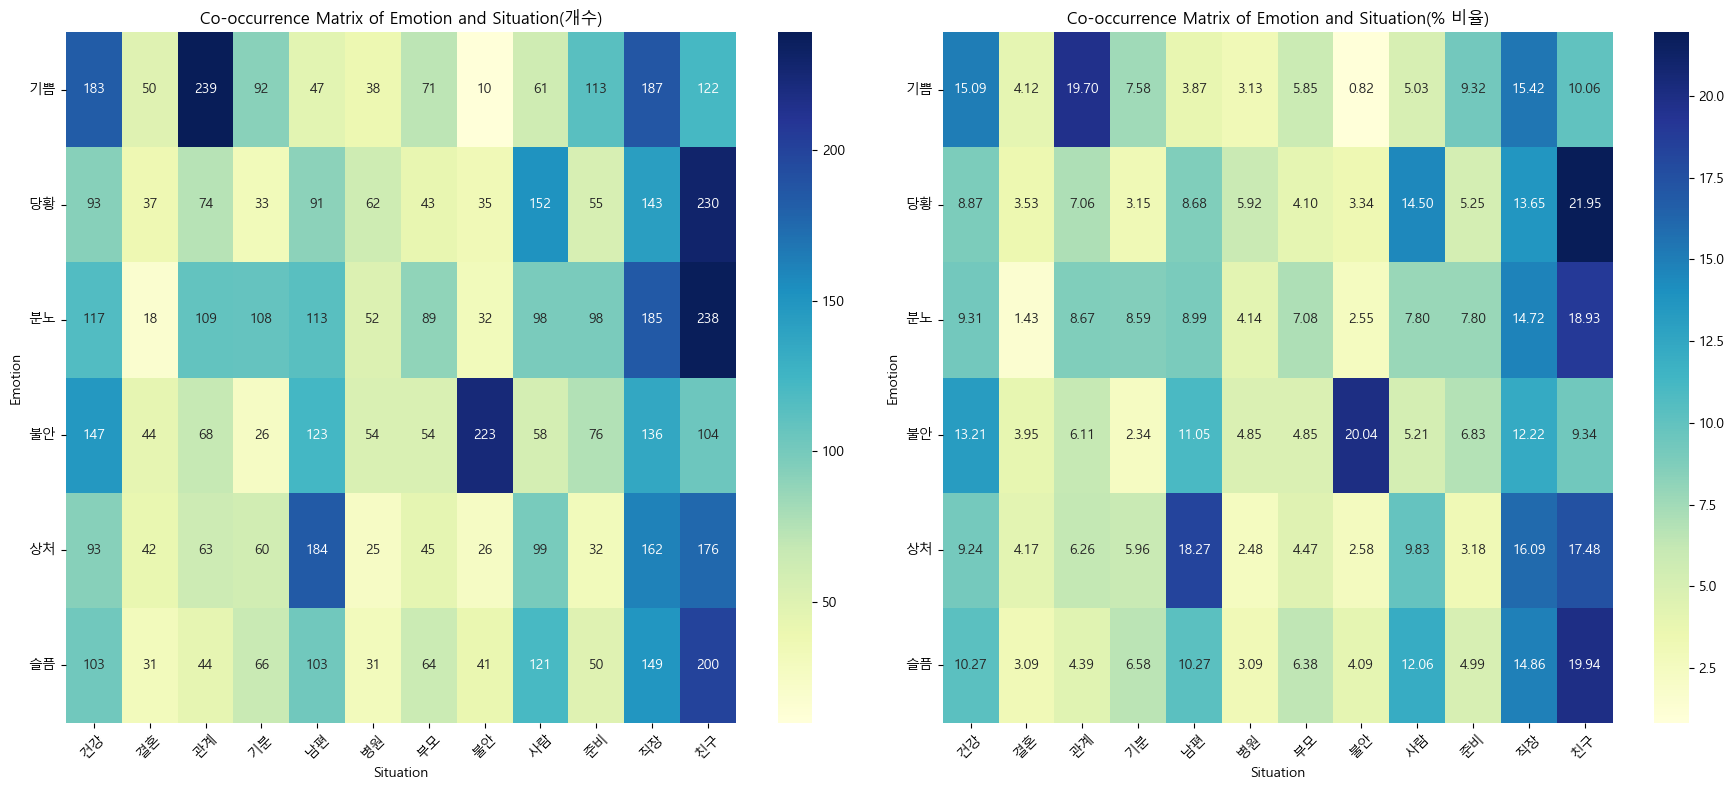

In [46]:
# '감정_대분류'와 '상황키워드'에 대한 co-occurrence matrix 계산
co_occurrence_matrix = pd.crosstab(df['감정_대분류'], df['주제별_첫번째_토픽'])

# 각 셀의 값에 대해 해당 행의 총합으로 나눈 백분율을 계산합니다.
# (axis=1은 행을 기준으로 계산하도록 함)
co_occurrence_percent = co_occurrence_matrix.div(co_occurrence_matrix.sum(axis=1), axis=0) * 100

# 그래프로 나타내기 위해 Seaborn의 heatmap을 사용합니다.
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 첫 번째 heatmap: co-occurrence matrix의 개수
sns.heatmap(co_occurrence_matrix, cmap="YlGnBu", annot=True, fmt="d", ax=axes[0])
axes[0].set_title("Co-occurrence Matrix of Emotion and Situation(개수)")
axes[0].set_xlabel("Situation")
axes[0].set_ylabel("Emotion")
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# 두 번째 heatmap: co-occurrence matrix의 백분율 (반올림하여 소수점 두 자리까지 표시)
sns.heatmap(co_occurrence_percent, cmap="YlGnBu", annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title("Co-occurrence Matrix of Emotion and Situation(% 비율)")
axes[1].set_xlabel("Situation")
axes[1].set_ylabel("Emotion")
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# 엑셀 파일로 저장
co_occurrence_matrix.to_excel('co_occurrence_matrix2.xlsx')
co_occurrence_percent.to_excel('co_occurrence_percent2.xlsx')